In [13]:
import numpy as np
import importlib
from datetime import datetime
import gc
import json
import os

In [14]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" # second gpu

In [15]:
from helpers import pre_processing_wlan_utils as preprocess_utils
from helpers import classifier_wlan_spectral_utils as classifier_utils
from helpers import tr_models as tr_models

In [16]:
importlib.reload(tr_models)
importlib.reload(classifier_utils)
importlib.reload(preprocess_utils)

1 Physical GPUs, 1 Logical GPUs


<module 'helpers.pre_processing_wlan_utils' from 'C:\\Users\\migue\\development\\traffic-recognition-2020\\source_code\\python\\helpers\\pre_processing_wlan_utils.py'>

In [3]:
seed = 42
task = "app"
label = preprocess_utils.label_index[task]
num_classes = preprocess_utils.num_classes[task]
labels_string = preprocess_utils.labels_string[task]

#adapting for 7 labels
num_classes = num_classes-1
del labels_string[7]
print("Label id: ", label)
print("Num classes in that label: ", num_classes)
print("Labels: ", labels_string)
max_iq_samples = [1000]#[100, 300, 500, 700, 1000, 2000]
print(max_iq_samples)

padding = 'post'
load_model=False
load_dir='../../models/'
load_file = '22042020175144_saved_wavenet_classifier'
num_repetitions = np.arange(0,2)
print(num_repetitions)
now = datetime.now()
datenow = now.strftime('%d%m%y%H%M%S')
show_model = True

models_parameters = {}
models_to_train = ['CNN']

Label id:  3
Num classes in that label:  7
Labels:  ['spotify', 'tunein', 'gpodcast', 'youtube', 'netflix', 'twitch', 'no-app']
[1000]
[0 1]


In [4]:
#Parameters for CNN
model_param={}
model_param['max_epochs']=2
model_param['kernel_size']=32
model_param['n_filters']=8
model_param['dropout']=0.1
model_param['batch_size']=32
models_parameters[models_to_train[0]]=model_param

In [5]:
dataset_folder = '../../dataset/waveforms/'
dataset_filename = 'waveforms_SNR_v2_16042020_2G_n_mobile_7_classes_app_balanced.mat'
#dataset_filename = 'waveforms_07082020_2G_n_mobile_L8_SNR_app_balanced.mat'
#dataset_filename = 'waveforms_16042020_2G_n_mobile_7_classes_app_balanced.mat'

In [6]:
gc.collect()

73

In [7]:
Xraw, Yraw = classifier_utils.get_raw_xy_spectrum(dataset_folder,dataset_filename)

100%|██████████| 71603/71603 [01:18<00:00, 907.92it/s] 


  0%|          | 309/71603 [00:00<00:23, 3059.49it/s]

Padding/Truncating sequence  1000


100%|██████████| 71603/71603 [00:26<00:00, 2730.44it/s]


Oneshot labels
Labels created
Performing data splitting
Starting first partitioning
First partitioning done. Starting partitioning 2
Final partitioning done
(57282, 2, 1000) (7160, 2, 1000) (7161, 2, 1000)
This is experiment:  0  with  1000
Starting data preparation and training for model  CNN
Re-shaping for CNN
(57282, 2, 1000, 1) (7160, 2, 1000, 1) (7161, 2, 1000, 1)
Creating the model
Model type CNN
Model parameters: kernel size  32 , number of filter  8 , and dropout  0.1
Model created
Model start training
Training for  2  epochs and batch size  32
Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

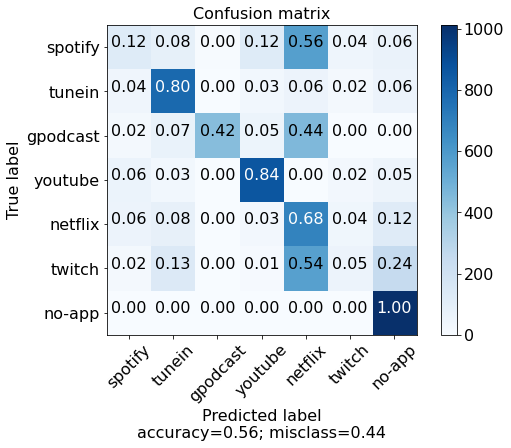

This is experiment:  1  with  1000
Starting data preparation and training for model  CNN
Re-shaping for CNN
(57282, 2, 1000, 1) (7160, 2, 1000, 1) (7161, 2, 1000, 1)
Creating the model
Model type CNN
Model parameters: kernel size  32 , number of filter  8 , and dropout  0.1
Model created
Model start training
Training for  2  epochs and batch size  32
Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1789/1791 [==============

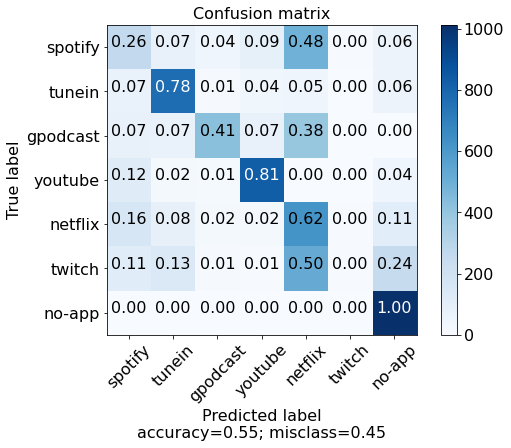

In [8]:
experiment_results = {}

for num_iq_seq in max_iq_samples:
    
    prefix = str(datenow)+"_app"+"_iq_samples_"+str(num_iq_seq)
    gc.collect()
    time.sleep(2)
    print("Padding/Truncating sequence ",str(num_iq_seq))
    X = classifier_utils.pad_or_trunc_x_and_scale(Xraw, num_iq_seq, padding, scale=False)
    time.sleep(2)
    
    print("Oneshot labels")
    Y = classifier_utils.get_one_hot_labels(Yraw, num_classes, label)
    
    print("Performing data splitting")
    X_train, X_val, X_test, Y_train, Y_val, Y_test = classifier_utils.get_xy_4_training(X,Y,seed)
    print(X_train.shape,X_val.shape, X_test.shape)

    gc.collect()
    for exp in num_repetitions:
        print("This is experiment: ", str(exp), " with ", str(num_iq_seq))
        
        for model_type in models_to_train:

            prefix_model = prefix+'_'+model_type+'_iq_samples_'+str(num_iq_seq)+'_num_classes_'+str(num_classes)+'_experiment_'+str(exp)+'_'+task

            print('Starting data preparation and training for model ', model_type)
            X_train_rs, X_val_rs, X_test_rs = classifier_utils.reshape_for_model(model_type, X_train, X_val, X_test)
            print(X_train_rs.shape,X_val_rs.shape, X_test_rs.shape)
            gc.collect()

            
            epochs = models_parameters[model_type]['max_epochs']
            kernel_size= models_parameters[model_type]['kernel_size']
            n_filters = models_parameters[model_type]['n_filters']
            dropout = models_parameters[model_type]['dropout']
            batch_size = models_parameters[model_type]['batch_size']
 
            result, model = classifier_utils.create_and_train_model(model_type, num_iq_seq, num_classes, prefix_model, 
                                                                    X_train_rs, Y_train, X_val_rs, Y_val, 
                                                                    X_test_rs, Y_test, save=True, 
                                                                    epochs = epochs, n_filters=n_filters, 
                                                                    dropout=dropout, kernel_size=kernel_size, batch_size=batch_size)


            epoch_times = model.get_time_per_epoch()
            #mean_training_time_epoch = np.mean(epoch_times, axis=0)
            #print(epoch_times, mean_training_time_epoch)

            result['epoch_times']=epoch_times
            experiment_results = classifier_utils.add_result(experiment_results, model_type, num_iq_seq, result, model_param, labels_string)


            if exp ==1 & show_model:
                model.get_model().summary()

            #print(model_type, num_iq_seq, experiment_results)

            #Save conf matrix
            classifier_utils.compute_and_save_conf_matrix(model, X_test_rs, Y_test, labels_string, filename_prefix = prefix_model, precision = "{:0.2f}")
            gc.collect()

In [9]:
result_file_name = str(datenow)+'_'+task+'_results.json'
classifier_utils.save_results_to_json(result_file_name,experiment_results)

In [10]:
with open(result_file_name) as json_file:
    results_back = json.load(json_file)

In [ ]:
print(json.dumps(results_back, indent=4))

In [ ]:
classifier_utils.compute_and_save_conf_matrix(model, X_test_rs, Y_test, labels_string, filename_prefix = prefix_model, precision = "{:0.2f}")

In [11]:
classifier_utils.compute_and_save_conf_matrix(model, X_test_rs, Y_test, labels_string, filename_prefix = prefix_model, precision = "{:0.2f}")

{
    "CNN": {
        "1000": [
            {
                "Training": [
                    1.0955454111099243,
                    0.5629866123199463
                ],
                "Validation": [
                    1.1116032600402832,
                    0.5568435788154602
                ],
                "Test": [
                    1.1015278100967407,
                    0.5553693771362305
                ],
                "prediction_time_training": {
                    "n_samples": 57282,
                    "time_pred": 14.4454312,
                    "t_sample": 0.0002521809853007926
                },
                "prediction_time_testing": {
                    "n_samples": 7161,
                    "time_pred": 1.924975899999998,
                    "t_sample": 0.00026881383884932243
                },
                "confusion_matrix_normalized": [
                    [
                        0.12121212121212122,
                        0.082111436950146

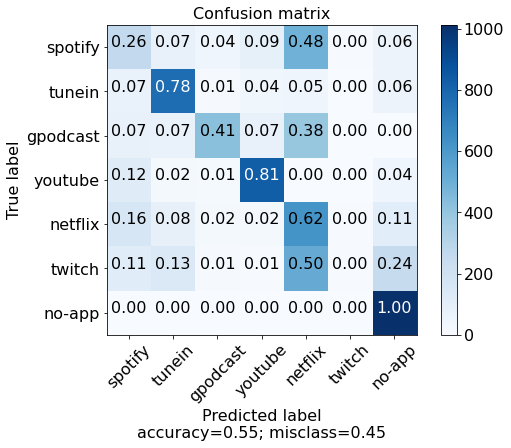

In [12]:
classifier_utils.compute_and_save_conf_matrix(model, X_test_rs, Y_test, labels_string, filename_prefix = prefix_model, precision = "{:0.2f}")